## Intro
This notebook will:
#### extrac the embeddings for each model (baseline vs fine tuned) 
#### train a shallow model (xgboost ) 
#### test the validation set accuracy against the shallow model results 


In [1]:
import pathlib
import torch

from esm import FastaBatchedDataset, pretrained

In [2]:
use_raw_model = False

In [3]:
from transformers import AutoTokenizer, EsmForSequenceClassification
import torch
from pathlib import Path


from transformers import AutoModelForSequenceClassification, AutoModel, EsmForSequenceClassification
# Example usage
#peft_model_path = "/home/salaris/protein_model/models/esm_finetuned_accelerated/visionary-lake-1/"
# peft_model_path = "/home/salaris/protein_model/seq_models/esm_finetuned_accelerated/sweet-dawn-9/"
# peft_model_path = "/home/salaris/protein_model/seq_models/esm_finetuned_accelerated/faithful-fog-9/"
# peft_model_path = "/home/salaris/protein_model/seq_models/esm_finetuned_accelerated/solar-dew-10/"
peft_model_path = "/home/salaris/protein_model/seq_models/esm_finetuned_accelerated/jolly-capybara-19/"


# base_model_path = "/home/salaris/protein_model/models/base_model_accelerated/"
base_model_path = "/home/salaris/protein_model/seq_models/esm2_t30_150M_UR50D_base_model_accelerated/"
# config_path = "/home/salaris/protein_model/models/esm_finetuned_accelerated/adapter_config.json"


In [4]:
# load the trainig set 
import pandas as pd
# training_set_path = "/home/salaris/protein_model/data/all_data_20240704_14.csvtrain_test.csv"
# validation_set_path = "/home/salaris/protein_model/data/all_data_20240704_14.csvtfinal_validation.csv"

# Mohammad
training_set_path = "/home/salaris/protein_model/data_binary/all_data_20240712_05.csvtrain_test.csv"
validation_set_path = "/home/salaris/protein_model/data_binary/all_data_20240712_05.csvtfinal_validation.csv"





In [5]:
from transformers import AutoTokenizer, EsmForSequenceClassification
import torch
from pathlib import Path

In [6]:
# 

In [7]:
#  output_model_file = /path/to/pytorch_mode.bin/
#  model_state_dict = torch.load(output_model_file) 
#  model = BertModel.from_pretrained(bert_model, state_dict=model_state_dict)


from transformers import AutoTokenizer, EsmForSequenceClassification
import torch
from pathlib import Path

def load_model(base_model_path, peft_model_path,only_raw_model = False):
    """
    Load the fine-tuned model and tokenizer from the given local path.
    """
    base_path = Path(base_model_path)
    model_path = Path(peft_model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)
    if not only_raw_model:
        # method1
        #model_state_dict = torch.load(f"{peft_model_path}/model.pth")
        #model = EsmForSequenceClassification.from_pretrained(base_model_path, local_files_only=True,state_dict = model_state_dict)

        #method 2
        model = EsmForSequenceClassification.from_pretrained(base_model_path, local_files_only=True)
        model.load_adapter(peft_model_path)
        # print('loading the finetuned model')
    else:
        model = EsmForSequenceClassification.from_pretrained(base_model_path, local_files_only=True)
        # model = EsmForSequenceClassification.from_pretrained("facebook/esm2_t6_8M_UR50D")
        # print('loading the raw model')
        
    model.eval()  # Set the model to evaluation mode
    return model, tokenizer

def predict_sequence(model, tokenizer, sequence, max_length=512, to_cuda = True):
    """
    Predict the class of the given sequence using the fine-tuned model.
    """
    # Preprocess the input sequence
    inputs = tokenizer(sequence, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    inputs = {key: val.to(model.device) for key, val in inputs.items()}
    if to_cuda:
        inputs.cuda()
    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

    return predictions.cpu().numpy()



In [23]:
              
# def extract_embeddings(base_model_path, tuned_model_path, seq_list , output_dir, seq_length = 1024, repr_layer = [-1], only_raw_model = None):
#     from transformers import EsmTokenizer, EsmModel
#     import torch
#     model,tokenizer = load_model(base_model_path = base_model_path, peft_model_path = tuned_model_path,only_raw_model = only_raw_model)
#     if torch.cuda.is_available():
#         model = model.base_model.cuda()
#         model = torch.nn.DataParallel(model)
                
#     seqs =seq_list
#     inputs = tokenizer(seqs, return_tensors="pt", padding=True, truncation=True,max_length = seq_length)
    
#     with torch.no_grad():
#         outputs = model(**inputs)
 
#     last_hidden_states = outputs.last_hidden_state
#     x = last_hidden_states.detach()
#     # x= x.mean(axis=1)
#     # mask = text != self.pad_token
#     denom = torch.sum(mask, -1, keepdim=True)
#     emb = torch.sum(x, dim=1) / denom.cuda()
#     return(emb)




# def extract_embeddings(base_model_path, tuned_model_path, seq_list , output_dir, seq_length = 1024, repr_layer = [-1], only_raw_model = None):
#     from transformers import EsmTokenizer, EsmModel
#     import torch
#     model,tokenizer = load_model(base_model_path = base_model_path, peft_model_path = tuned_model_path,only_raw_model = only_raw_model)
#     if torch.cuda.is_available():
#         model = model.base_model.cuda()
#         model = torch.nn.DataParallel(model)
                
#     seqs =seq_list
#     inputs = tokenizer(seqs, return_tensors="pt", padding=True, truncation=True,max_length = seq_length)
    
#     with torch.no_grad():
#         last_hidden_state = model(**inputs, output_hidden_states=True).hidden_states[-1].cuda()


#     weights_for_non_padding = inputs.attention_mask.cuda() * torch.arange(start=1, end=last_hidden_state.shape[1] + 1).unsqueeze(0).cuda()

#     sum_embeddings = torch.sum(last_hidden_state * weights_for_non_padding.unsqueeze(-1), dim=1)
#     num_of_none_padding_tokens = torch.sum(weights_for_non_padding, dim=-1).unsqueeze(-1)
#     sentence_embeddings = sum_embeddings / num_of_none_padding_tokens
    
#     return(sentence_embeddings)



def load_model(base_model_path, peft_model_path,only_raw_model = False):
    """
    Load the fine-tuned model and tokenizer from the given local path.
    """
    base_path = Path(base_model_path)
    model_path = Path(peft_model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)
    if not only_raw_model:
        # method1
        #model_state_dict = torch.load(f"{peft_model_path}/model.pth")
        #model = EsmForSequenceClassification.from_pretrained(base_model_path, local_files_only=True,state_dict = model_state_dict)

        #method 2
        model = EsmForSequenceClassification.from_pretrained(base_model_path, local_files_only=True)
        model.load_adapter(peft_model_path)
        # print('loading the finetuned model')
    else:
        model = EsmForSequenceClassification.from_pretrained(base_model_path, local_files_only=True)
        # model = EsmForSequenceClassification.from_pretrained("facebook/esm2_t6_8M_UR50D")
        # print('loading the raw model')
        
    model.eval()  # Set the model to evaluation mode
    return model, tokenizer


def extract_embeddings(model,tokenizer, seq_list, seq_length = 1024):
    from transformers import EsmTokenizer, EsmModel
    import torch
    if torch.cuda.is_available():
        model = model.base_model.cuda()
        model = torch.nn.DataParallel(model)
                
    seqs =seq_list
    inputs = tokenizer(seqs, return_tensors="pt", padding=True, truncation=True,max_length = seq_length)
    
    with torch.no_grad():
        outputs = model(**inputs)
 
    last_hidden_states = outputs.last_hidden_state
    x = last_hidden_states.detach()
    mask = inputs['attention_mask']
    # mask = text != self.pad_token
    denom = torch.sum(mask, -1, keepdim=True)
    emb = torch.sum(x, dim=1) / denom.cuda()

    # x= x.mean(axis=1)
    # return(emb)
    return(x, denom, mask,emb)

In [9]:
# caslist = ['cas1','cas2','cas3','cas4','cas5','cas6','cas7','cas8','cas9','cas10','cas11','cas12','cas13']


In [10]:
model_name = 'esm2_t33_650M_UR50D'


In [11]:
torch.cuda.empty_cache()


In [12]:
# base_model_path = "/home/salaris/protein_model/models/base_model_accelerated/"
# tuned_model_path ="/home/salaris/protein_model/models/esm_finetuned_accelerated/"

# # seq = """MQIGKVQGRTISEFGDPAGGLKRKISTDGKNRKELPAHLSSDPKALIGQWISGIDKIYRKPDSRKSDGKAIHSPTPSKMQFDARDDLGEAFWKLVSEAGLAQDSDYDQFKRRLHPYGDKFQPADSGAKLKFEADPPEPQAFHGRWYGAMSKRGNDAKELAAALYEHLHVDEKRIDGQPKR"""
# new_embeddings = extract_embeddings(base_model_path=base_model_path, tuned_model_path=tuned_model_path,
#                             seq_list = [seq1,seq2], output_dir = "")
# old_embeddings = extract_embeddings(base_model_path=base_model_path, tuned_model_path=tuned_model_path,
#                             seq_list = [seq1,seq2], output_dir = "",onlybase=False)

In [13]:
# new_embeddings - old_embeddings

## Load the training set:

In [14]:

training_set_df = pd.read_csv(training_set_path,sep = '\t')
validation_set_df = pd.read_csv(validation_set_path, sep = "\t")

In [15]:
seqlist = training_set_df.seq.to_list()
all_embeddings = []


model,tokenizer = load_model(base_model_path,peft_model_path=peft_model_path,only_raw_model=use_raw_model)
def chunk_list(input_list, chunk_size):
    """Yield successive chunks from input_list of size chunk_size."""
    for i in range(0, len(input_list), chunk_size):
        yield input_list[i:i + chunk_size]

for chunk in chunk_list(seqlist, chunk_size = 200):
    embeddings = extract_embeddings(model,tokenizer,
                                    seq_list = chunk  ,seq_length=1024)
    all_embeddings.extend(embeddings.cpu())
    
training_dataset = {'seq': training_set_df.seq, 
           'description': training_set_df.description,
           'record_id': training_set_df.record_id, 
          'class': training_set_df['class'],
          'embeddings': all_embeddings}
# save tensors to file 
if use_raw_model:
    print('saving raw training model')
    torch_file_name = training_set_path + "_raw.torch.pt"
else:
    print('saving finetuned training model')
    model_name = peft_model_path.split("/")[-2]
    torch_file_name = training_set_path + model_name +"_finetuned.torch.pt"

torch.save(training_dataset,torch_file_name)
print(torch_file_name)

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at /home/salaris/protein_model/seq_models/esm2_t30_150M_UR50D_base_model_accelerated/ and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


saving finetuned training model
/home/salaris/protein_model/data_binary/all_data_20240712_05.csvtrain_test.csvjolly-capybara-19_finetuned.torch.pt


In [16]:
model_name = peft_model_path.split("/")[-2]
model_name

'jolly-capybara-19'

In [17]:
torch.cuda.empty_cache()


## Load the validation set:

In [19]:
model,tokenizer = load_model(base_model_path,peft_model_path=peft_model_path,only_raw_model=use_raw_model)

seqlist = validation_set_df.seq.to_list()
all_embeddings = []
def chunk_list(input_list, chunk_size):
    """Yield successive chunks from input_list of size chunk_size."""
    for i in range(0, len(input_list), chunk_size):
        yield input_list[i:i + chunk_size]

for chunk in chunk_list(seqlist, chunk_size = 200):
    embeddings = extract_embeddings(model,tokenizer, seq_list = chunk  ,seq_length=1024)
    all_embeddings.extend(embeddings.cpu())
    
validation_dataset = {'seq': validation_set_df.seq, 
           'description': validation_set_df.description,
           'record_id': validation_set_df.record_id, 
          'class': validation_set_df['class'],
          'embeddings': all_embeddings}
# save tensors to file 
if use_raw_model:
    print('saving raw validation model')
    torch_file_name = validation_set_path + "_raw.torch.pt"
else:
    print('saving finetuned validation model')
    model_name = peft_model_path.split("/")[-2]

    torch_file_name = validation_set_path + model_name +"_finetuned.torch.pt"
    
torch.save(validation_dataset,torch_file_name)
print(torch_file_name)

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at /home/salaris/protein_model/seq_models/esm2_t30_150M_UR50D_base_model_accelerated/ and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


saving finetuned validation model
/home/salaris/protein_model/data_binary/all_data_20240712_05.csvtfinal_validation.csvjolly-capybara-19_finetuned.torch.pt


In [20]:
use_raw_model

False

In [21]:
torch.cuda.empty_cache()


# remove these later

In [22]:
torch_file_name

'/home/salaris/protein_model/data_binary/all_data_20240712_05.csvtfinal_validation.csvjolly-capybara-19_finetuned.torch.pt'

In [24]:
model,tokenizer = load_model(base_model_path,peft_model_path=peft_model_path,only_raw_model=use_raw_model)


Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at /home/salaris/protein_model/seq_models/esm2_t30_150M_UR50D_base_model_accelerated/ and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
sequences = ["DQATSLRILNNGHAFNVEFDDSQDKAVLKGG","DQATSLRILNNGHAFNVEFDDSQDKAVLKGGPLDGTYRLIQFHFHWGSLDGQGSEHTVDKK"," KYAAELHLVHWNTKYGDFGKAVQQPDGLAVLGIFLKVGSAKPGLQKVVDVLDSIKTKSIKTKGKSADFTNFDPRGLLPESLDYWTYPGSLTTPP"]

In [50]:
x, denom, mask,emb = extract_embeddings(model , tokenizer, sequences,)

In [139]:
tokenizer(sequences)

AttributeError: 

In [52]:
mask.sum(axis = 1)

tensor([33, 63, 96])

In [53]:
x.shape

torch.Size([3, 96, 640])

In [57]:
x[0,:,:]

tensor([[-0.1034,  0.0947,  0.1180,  ..., -0.0982, -0.2665,  0.1100],
        [-0.1970, -0.0538,  0.1580,  ..., -0.1042, -0.1789, -0.2240],
        [ 0.1667,  0.1347,  0.1021,  ...,  0.1365, -0.2528,  0.0143],
        ...,
        [ 0.0385,  0.1485,  0.0223,  ..., -0.0620, -0.1584,  0.0570],
        [ 0.0473,  0.1671,  0.0287,  ..., -0.0631, -0.1732,  0.0255],
        [ 0.0731,  0.1770,  0.0294,  ..., -0.0317, -0.1554,  0.0045]],
       device='cuda:0')

In [152]:
import torch
from torchviz import make_dot
from esm import pretrained
from torchinfo import summary
# Load the pre-trained ESM2 model
model, alphabet = pretrained.esm2_t6_8M_UR50D()
model.eval()

batch_converter = alphabet.get_batch_converter()

# Define a sample input sequence
sequences = [("protein1", "MERLGLIEVQREARLGLIEVQQEARL")]
batch_labels, batch_strs, batch_tokens = batch_converter(sequences)

# Print a summary of the model
# You need to provide a sample input size. Here it uses the actual tokenized output shape
print(summary(model, input_data=batch_tokens, verbose=1))

Layer (type:depth-idx)                        Output Shape              Param #
ESM2                                          --                        --
├─Embedding: 1-1                              [1, 28, 320]              10,560
├─ModuleList: 1-2                             --                        --
│    └─TransformerLayer: 2-1                  [28, 1, 320]              --
│    │    └─LayerNorm: 3-1                    [28, 1, 320]              640
│    │    └─MultiheadAttention: 3-2           [28, 1, 320]              410,880
│    │    └─LayerNorm: 3-3                    [28, 1, 320]              640
│    │    └─Linear: 3-4                       [28, 1, 1280]             410,880
│    │    └─Linear: 3-5                       [28, 1, 320]              409,920
│    └─TransformerLayer: 2-2                  [28, 1, 320]              --
│    │    └─LayerNorm: 3-6                    [28, 1, 320]              640
│    │    └─MultiheadAttention: 3-7           [28, 1, 320]              4

torch.Size([2, 28, 33])


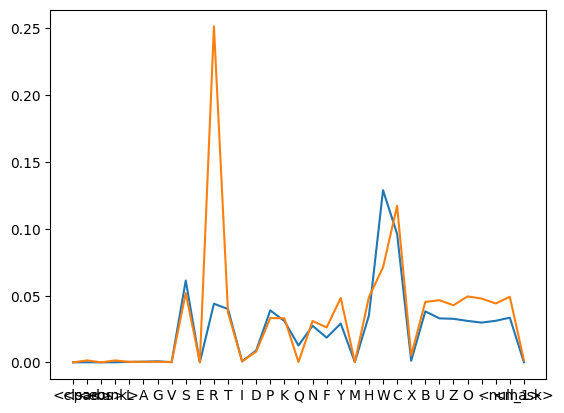

In [153]:
y.shape
yy = torch.softmax(y,dim = 1)
print(yy.shape)
plt.plot(all_tokens,yy[0,-6,:])
plt.plot(all_tokens,yy[1,-6,:])


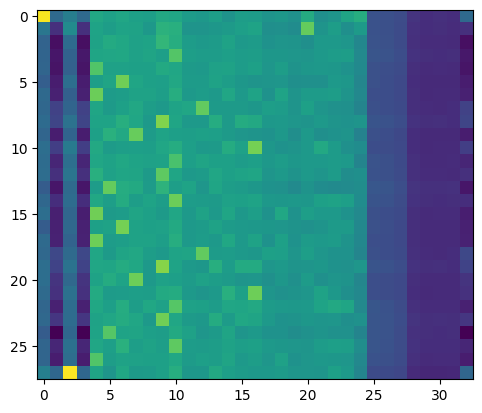

In [89]:
from matplotlib import pyplot as plt
plt.imshow(y[0,:,:])

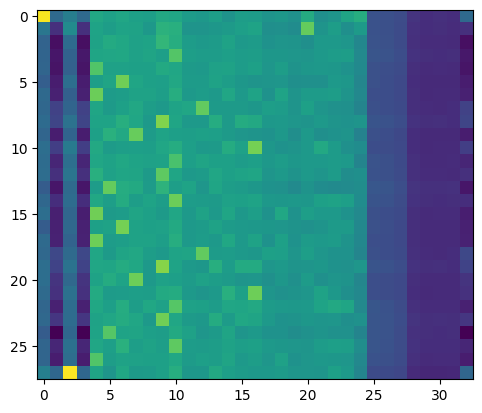

In [90]:
plt.imshow(y[0,:,:])

In [84]:
from esm import pretrained

# Load the pre-trained ESM2 model
model, alphabet = pretrained.esm2_t6_8M_UR50D()
model.eval()

# Print all tokens in the alphabet
all_tokens = alphabet.all_toks
print("Vocabulary tokens:", all_tokens)
print("Number of tokens in the vocabulary:", len(all_tokens))


Vocabulary tokens: ['<cls>', '<pad>', '<eos>', '<unk>', 'L', 'A', 'G', 'V', 'S', 'E', 'R', 'T', 'I', 'D', 'P', 'K', 'Q', 'N', 'F', 'Y', 'M', 'H', 'W', 'C', 'X', 'B', 'U', 'Z', 'O', '.', '-', '<null_1>', '<mask>']
Number of tokens in the vocabulary: 33


In [120]:
output

{'logits': tensor([[[ 14.5116,  -8.2826,  -5.1330,  ..., -15.1508, -15.3992,  -8.2861],
          [ -6.3762, -15.8363,  -4.0548,  ..., -15.4440, -15.7004, -15.8311],
          [ -9.0327, -18.8245,  -7.8812,  ..., -15.6019, -15.7464, -18.8135],
          ...,
          [ -8.8928, -17.1600,  -7.7431,  ..., -15.5502, -15.4684, -17.1553],
          [ -8.7543, -17.8476,  -8.1461,  ..., -15.6040, -15.6257, -17.8514],
          [ -4.7209,  -8.6143,  14.7602,  ..., -16.1701, -16.0789,  -8.6491]],
 
         [[ 14.7029,  -7.9352,  -5.1806,  ..., -15.1078, -15.3694,  -7.9422],
          [ -6.1455, -14.9152,  -2.7824,  ..., -15.4802, -15.7274, -14.9155],
          [ -8.7566, -18.0929,  -7.6082,  ..., -15.5468, -15.7005, -18.0819],
          ...,
          [ -8.1011, -15.9811,  -6.6479,  ..., -15.4207, -15.3473, -15.9809],
          [ -8.3873, -16.9582,  -7.3562,  ..., -15.5149, -15.5202, -16.9660],
          [ -4.7539,  -7.8621,  15.0468,  ..., -16.0860, -15.9839,  -7.8963]]]),
 'representations'

In [127]:
import torch
from esm import pretrained

# Load the pre-trained ESM2 model
model, alphabet = pretrained.esm2_t6_8M_UR50D()
model.eval()

# Create a batch converter for handling sequences
batch_converter = alphabet.get_batch_converter()

# Define sample input sequences with different lengths
sequences = [
    ("protein1", "MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQREARL"),
    ("protein2", "MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQREARLGLIEVQREARL")
]
batch_labels, batch_strs, batch_tokens = batch_converter(sequences)

# Create an attention mask (1 for actual tokens, 0 for padding)
# The batch_tokens tensor has shape (batch_size, sequence_length)
mask = (batch_tokens != alphabet.padding_idx).float()

# Forward pass through the model to get hidden states
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[model.num_layers])
    token_representations = results["representations"][model.num_layers]

# Apply the mask and compute the mean of valid tokens
masked_token_representations = token_representations * mask.unsqueeze(-1)
sum_representations = masked_token_representations.sum(dim=1)
mask_sum = mask.sum(dim=1, keepdim=True)
sequence_embedding = sum_representations / mask_sum

# Print the sequence embeddings
print(sequence_embedding)
print(f"Shape of sequence embedding: {sequence_embedding.shape}")


tensor([[-2.0106e-02, -3.5331e-01,  2.6595e-01,  1.8570e-01, -7.5212e-02,
         -1.1436e-01, -1.2769e-01,  2.1396e-02, -8.3994e-02, -9.4285e-02,
         -5.7693e-02,  2.3041e-01, -7.8533e-02,  1.3855e-01, -5.8065e-02,
          8.8589e-02,  5.5666e-02,  2.4312e-02,  1.4725e-01, -7.6505e-03,
         -8.4472e-02,  7.6898e-02, -8.1798e-02,  9.2253e-02,  1.0400e-01,
          1.2446e-01,  4.3806e-02,  7.6404e-02,  7.8559e-02, -2.1652e-01,
         -2.3314e-02,  1.0923e-02,  9.1769e-02, -1.3926e-01,  6.8006e-02,
         -4.2836e-01,  1.7558e-01, -7.1808e-02,  3.2158e-01,  8.4631e-02,
         -1.0539e-01,  2.9515e-01,  9.3193e-02, -1.6944e-01, -6.2296e-02,
          6.1790e-02, -1.2320e+00,  1.9016e-01, -1.0954e-02, -1.2591e-01,
          2.4725e-02, -1.3213e-01,  2.6787e-01,  9.1387e-03, -1.8292e-01,
         -1.8288e-01,  1.7039e-01,  1.2718e-02,  5.2696e-03, -1.0016e-01,
         -1.0400e-02, -1.1155e-01, -5.2193e+00, -6.8866e-02,  5.4138e-02,
          2.1309e-02,  4.7668e-02, -2.